In [1]:
!pip install transformers
!pip install datasets
# !pip install wandb



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install xformers


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import torch.nn as nn
import torch
from transformers import pipeline, set_seed
from transformers import GPT2Tokenizer


class MLP(nn.Module):
    ## multi layer perceptron thats inserted into distilgpt2
    ## function is simple, its 2 linear layers that take the output of the transformer in distilgpt2 and it learns to steer the text into making better prompts
    ## however, we only want to update parameters for the 2 linear layers, not the rest, hence the requires grad being set to false
    ## output of the lm_head in this case is our Q value
    ## lm_head outputs 50k size tensors, and it's argmax is the token that it represents (aka which word to pick out of the 50k vocab size)
    ## according to the paper, this 50k size tensor also represents Q value since it decides which word to pick for our prompt
    ## our 2 linear layers get fed in states aka the previous prompts that we've generated
    ## they learn the appropriate Q value that the lm_head should output for the action of picking a word based on current reward and discounted max future reward (aka the target)
    def __init__(self):
        super().__init__()
        self.lm_pipeline = pipeline('text-generation', model='distilgpt2')
        self.policy = nn.Sequential(
            nn.Linear(768, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, 768),
#             nn.ReLU(),
        )
        def _init_weights(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.0001)
                m.bias.data.fill_(-0.0001)
        self.policy.apply(_init_weights)
        self.lm_pipeline.model.lm_head.requires_grad_(False)
        self.lm_pipeline.model.transformer.requires_grad_(False)
        self.lm_pipeline.model.lm_head = self.lm_pipeline.model.lm_head.to(device)
        self.lm_pipeline.model.transformer = self.lm_pipeline.model.transformer.to(device)
        self.tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2', truncation_side = 'left')
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.lm_pipeline.model.train()
    def forward(self, x):
        # assert(x.shape[1] == 768)
        # print(x.shape)
        x = self.policy(x)
        return self.lm_pipeline.model.lm_head(x)
    def truncate(self, x):
        arr1 = []
        arr2 = []
        for i in x:
            token = self.tokenizer([i], return_tensors = 'pt')
            inp = token['input_ids'][0,-3:]
            masks = token['attention_mask'][0,-3:]
            arr1.append(inp)
            arr2.append(masks)
        return {'input_ids':torch.cat(arr1).reshape(len(x),-1), 'attention_mask': torch.cat(arr2).reshape(len(x),-1)}
            
    def get_lm_output(self, x):
        with torch.no_grad():
          input = self.truncate(x)
          for key, value in zip(input.keys(), input.values()):
            input[key] = value.to(device)
          return self.lm_pipeline.model.transformer(**input, use_cache=True).last_hidden_state
    def get_prompt(self, x):
        # print(x.shape)
        return  self.lm_pipeline.tokenizer.decode(x.softmax(-1).argmax(-1).reshape(1))
    def get_prompt_greedy(self, x, epsilon):
        # print(x.shape)
        if torch.rand(1) < epsilon:
            return  self.lm_pipeline.tokenizer.decode(torch.randint(0, x.shape[-1], (1,)))
        return  self.lm_pipeline.tokenizer.decode(x.softmax(-1).argmax(-1).reshape(1))
    def get_prompt_softmax_greedy(self, x):
        # print(x.shape)
        return  self.lm_pipeline.tokenizer.decode()
    

In [4]:
from transformers import pipeline

import torch
device = 'mps'

class MLM():
  ### Our masked LM model
  ### no learning involved here, just try to get the reward for having it fill it with good vs bad
  def __init__(self):
   self.unmasker = pipeline('fill-mask', model='distilroberta-base')

  def get_masked_word_class(self, input, prompt):
    return self.unmasker(f'{input} {prompt} <mask>', targets = ['good', 'bad'])




In [5]:

import torch
from tqdm import tqdm
# import wandb
### we have states which represents words that we feed into the distilgpt to get better words/prompts
### prompt at time t is a result of picking the action from the mlp that results in the highest reward
### can be written as argmax(reward(MLP(states)), arg = prompt)
### our loss/regression target is essentially reward+discount*max(Q(s_t+1, a'_t+1) for all a')
### this technically isn't the softqlearner, and is generally unstable and produces sparse rewards and takes an extremely long time to train
class QLearner():

    def __init__(self):
        self.mlm = MLM()
        self.mlp = MLP().to(device)
        self.target = MLP().to(device)
#         self.target.load_state_dict(self.mlp.state_dict())
        # torch.manual_seed(95)

        self.last_state = 'this'
        self.prompt_reward = [0]
        self.max_reward = 0
        self.optimizer = torch.optim.AdamW(self.mlp.parameters(), lr=1e-4)
        self.accuracy = []
        self.val_acc = []
        self.loss_ = []
        self.epsilon = .9
    def randomize(self, Q, epsilon): 
#         print("max, min ", Q.max(), Q.min())
        r = torch.rand(1)
#         print('before')
#         print(Q.argmax(-1))
        if r < epsilon:
            index = torch.randint(0, Q.shape[-1], (1,))
            
            m = Q.max().item()
            m = 1 if m == 0 else m
            detached = Q.detach()
#             print('index and max prob',index,m)
            detached[:] = 0
            detached[index] = m
#             print('prob:',r)
#         print('after')
#         print(Q.argmax(-1))
        return Q
    # gets the actions for every state, and their Q values. actions in this case are the prompts
    def get_actions_Q (self, last_state):
        actions = []
        Q = []
        for i in range(5):
          lm_output = self.mlp.get_lm_output([last_state]).to(device) 
          Q_ = self.mlp(lm_output)
          Q.append(Q_)
          last_state = self.mlp.get_prompt(Q_)
          actions.append(last_state)
        if type(actions) == str:
          actions = [actions]
        return actions, torch.cat(Q), last_state

    def get_actions_Q_target (self, last_state):
        actions = []
        Q = []
        for i in range(5):
          lm_output = self.target.get_lm_output([last_state]).to(device) 
          Q_ = self.target(lm_output)
          Q.append(Q_)
          last_state = self.target.get_prompt(Q_)
          actions.append(last_state)
        if type(actions) == str:
          actions = [actions]
        return actions, torch.cat(Q), last_state


    def get_actions_Q_input_specific (self, batch_input):
        actions = []
#         print(len(batch_input))
        lm_output = self.mlp.get_lm_output(batch_input).to(device) 
        Q_ = self.mlp(lm_output)
    
#         print(Q_.shape)
        Q_ = Q_[:,-1].reshape(Q_.shape[0], Q_.shape[-1]) #(16, 50k)
        for i in range(Q_.shape[0]):
          actions.append([self.mlp.get_prompt(Q_[i])])
        
        Q = [[self.randomize(Q_[i], self.epsilon).reshape(1, Q_.shape[-1])] for i in range(Q_.shape[0])]



        for i in range(4):
          lm_output = self.mlp.get_lm_output([ batch_input[j]+"".join(actions[j]) for j in range(len(actions))]).to(device) 
          Q_ = self.mlp(lm_output)
        
          Q_ = Q_[:,-1].reshape(Q_.shape[0], Q_.shape[-1])
          for j in range(Q_.shape[0]):
            Q[j].append(self.randomize(Q_[j], self.epsilon).reshape(1, Q_.shape[-1]))
          
          for j in range(Q_.shape[0]):
            actions[j].append(self.mlp.get_prompt(Q_[j]))
        if type(actions) == str:
          actions = [actions]
        # print(Q)
        # print(actions)
        Q = [torch.cat(Q__).reshape(1,5,-1) for Q__ in Q]
        # print(torch.cat(Q).shape)
        return actions, torch.cat(Q)

    def get_actions_Q_input_specific_target (self, batch_input):
        actions = []

        lm_output = self.target.get_lm_output(batch_input).to(device) 
        Q_ = self.target(lm_output)
        Q_ = Q_[:,-1].reshape(Q_.shape[0], Q_.shape[-1])
        for i in range(Q_.shape[0]):
          actions.append([self.mlp.get_prompt(Q_[i])])
        Q = [[Q_[i].reshape(1, Q_.shape[-1])] for i in range(Q_.shape[0])]



        for i in range(4):
          lm_output = self.mlp.get_lm_output([batch_input[j]+"".join(actions[j]) for j in range(len(actions))]).to(device) 
          Q_ = self.target(lm_output)
          Q_ = Q_[:,-1].reshape(Q_.shape[0], Q_.shape[-1])
          for j in range(Q_.shape[0]):
            Q[j].append(Q_[j].reshape(1, Q_.shape[-1]))
          
          for j in range(Q_.shape[0]):
            actions[j].append(self.mlp.get_prompt(Q_[j]))
        if type(actions) == str:
          actions = [actions]

        Q = [torch.cat(Q__).reshape(1,5,-1) for Q__ in Q]
        # for i in Q:
        #   for j in i:
        #     print(j.shape)
        # print(torch.cat(Q).shape)
        return actions, torch.cat(Q)

    # to be updated but currently the reward is set to how many correct classifications can this model make
    def get_reward(self, train_x, train_y, prompt):
        reward = 0
        count = 0
#         if '�' in prompt or 'Ġ' in prompt:
#             return -10000
        for sentence, cls in zip(train_x, train_y):
                word_cls = self.mlm.get_masked_word_class(sentence, prompt)
#                 if (word_cls[0]['token_str'] == 'good' and cls == 1) or (word_cls[0]['token_str'] == 'bad' and cls == 0):
#                     reward = 
#                 else:
#                     incorrect +=1
                if (word_cls[0]['token_str'] == 'good' and cls == 1) or (word_cls[0]['token_str'] == 'bad' and cls == 0):
                    reward += (word_cls[0]['score']- word_cls[1]['score'])
                else:
                    reward += (word_cls[1]['score']- word_cls[0]['score'])
                count +=1
        return reward/count
    def get_accuracy(self, train_x, train_y, prompt):
        count = 0
        accurate = 0
        for sentence, cls in zip(train_x, train_y):
                word_cls = self.mlm.get_masked_word_class(sentence, prompt)
                if (word_cls[0]['token_str'] == 'good' and cls == 1) or (word_cls[0]['token_str'] == 'bad' and cls == 0):
                    reward = word_cls[0]['score']- word_cls[1]['score']
                else:
                    reward = word_cls[1]['score']- word_cls[0]['score']
                count +=1
                accurate = accurate + 1 if reward >0 else accurate
        return accurate/count
  
    def loss(self, train_x, train_y):

        actions, Q = self.get_actions_Q_input_specific(train_x)
#         print(Q.shape)
        reward = torch.tensor([self.get_reward(train_x, train_y, ' '.join(action)) for action in actions]).to(device)
        accuracy = torch.tensor([self.get_accuracy(train_x, train_y, ' '.join(action)) for action in actions])
#         reward = high_reward*2-1
#         reward = high_reward
        
        reward = (200**(reward>0))*(100**(reward<=0))*reward
        if reward.std() > 1e-3:
            reward = (reward-reward.mean())/reward.std()
        with torch.no_grad():
          actions_, Q_, = self.get_actions_Q_input_specific_target(train_x)
        return torch.nn.functional.mse_loss(\
            Q, \
            reward.reshape(-1,1,1)+\
            0.99*Q_.detach()), accuracy, [' '.join(action) for action in actions]
    
    def get_accuracy_(self, val_x, val_y, prompts):
#         print(prompts)
        return torch.tensor([self.get_accuracy(val_x, val_y, prompt) for prompt in prompts]).mean()


    def train(self, train_x, train_y, val_x, val_y, epochs):
        
        for i in tqdm(range(epochs)):
            self.optimizer.zero_grad()
            loss, reward, prompts = self.loss(train_x, train_y)
            loss.backward()
            self.optimizer.step()
#             train_accuracy = self.get_accuracy_(train_x, train_y, prompts)
#             val_accuracy = self.get_accuracy_(val_x, val_y, prompts)
            self.accuracy.append(reward.mean())
            self.loss_.append(loss.item())
            
            if i %30 == 0:
                self.epsilon = self.epsilon*.9
            
            if i %10==0:
              target_weights = self.target.state_dict()
              for key in target_weights:
                target_weights[key] = self.mlp.state_dict()[key] 
              self.target.load_state_dict(target_weights)
              
              val_accuracy = self.get_accuracy_(val_x, val_y, prompts)
              self.val_acc.append(val_accuracy)
              print(f'loss:{loss.item()}, train_acc: {reward.mean()}, val_acc: {val_accuracy}')
              print(f'prompts: {prompts}')
#               wandb.log({"train_acc": reward.mean(), "val_accuracy": val_accuracy, 'prompts':prompts })
            

In [6]:

ql = QLearner()

In [7]:
import pandas as pd
train_x = list(pd.read_csv('sst2_train')['sentence'])
train_y = list(pd.read_csv('sst2_train')['label'])

val_x = list(pd.read_csv('sst2_val')['sentence'])
val_y = list(pd.read_csv('sst2_val')['label'])

In [8]:
import random

# # start a new wandb run to track this script
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="DQN RLPrompt LOCAL MPS",
    
#     # track hyperparameters and run metadata
#     config={
#     "learning_rate": 1e-4,
#     "architecture": "DQN",
#     "dataset": "sst",
#     "epochs": 2999,
#     }
# )
ql.train(train_x, train_y, val_x, val_y, epochs = 2999)

  0%|                                     | 1/2999 [01:08<57:03:08, 68.51s/it]

loss:0.8749993443489075, train_acc: 0.53125, val_acc: 0.5043749809265137
prompts: [' Image 503 ievers inks  airst', ' Image  liberated  granting  lightsaber  graffiti', ' Image fman message oser  Uniform', ' Image  gre ald  RELEASE ifled', ' Image  sake l  Delhi  205', ' Image  studies  filing  Nexus  gcc', ' Image  requiring  Force  Apostles  Gerrard', ' Image North  Militia reb osph']


  0%|▏                                   | 11/2999 [03:04<20:55:49, 25.22s/it]

loss:3.0630177207058296e-05, train_acc: 0.578125, val_acc: 0.5225000381469727
prompts: [' of  of  Harvey  Explos  overhaul', ' of  Bj  of outheastern  of', ' of rors  kingdoms  reside five', ' of CSS  vantage  Lindsay  Rel', ' of  people  behaves eway  of', ' of  MB  of  Spokane  calls', ' of  bestowed policy  dism  of', ' of  of  possibly  expenditure  Pharma']


  1%|▎                                   | 21/2999 [05:00<20:35:51, 24.90s/it]

loss:0.00020589858468156308, train_acc: 0.546875, val_acc: 0.5218750238418579
prompts: [' of ribune  astronaut  adamant our', ' of cffff  of  of atis', ' of  pap level  triple luck', ' of ques 402  of Catalog', ' of  of special  dataset SL', ' of  Drill  Osaka  intervention  hep', ' of  Nico abil  of  of', ' of  likelihood  of  envelop Motor']


  1%|▎                                   | 31/2999 [06:55<20:18:10, 24.63s/it]

loss:0.0012749630259349942, train_acc: 0.59375, val_acc: 0.5249999761581421
prompts: [',  inspecting  dip  thriving  Equipment', ', pei ensical  shelling  spears', ',  Hansen ,  contains ,', ',  disposable  when , OST', ', ------------- Wa  Balance reat', ', , Origin , 174', ',  proven  blinding MAS ,', ', , cture  deep uming']


  1%|▍                                   | 41/2999 [08:50<20:16:01, 24.67s/it]

loss:0.00455052312463522, train_acc: 0.609375, val_acc: 0.5287500023841858
prompts: [', headers  Discuss  plentiful ,', ', 017  Siege STEP  couldn', ',  punct  inexplicable  Minimum ,', ', /.  current ,  rh', ',  related  Bars  Scriptures ,', ',  Essex  Ms aunder  four', ',  Barker  predicate  clothed ,', ',  Hollow  whipped  trance  respecting']


  2%|▌                                   | 51/2999 [10:45<20:07:01, 24.57s/it]

loss:0.01040890347212553, train_acc: 0.578125, val_acc: 0.5106250047683716
prompts: [',  McD ,  Robot  Gap', ', PH  ordinary ETS  ↑', ', or urance  poking rit', ',  elders lev , ,', ',  neighborhood asionally  Kre  overrun', ', , , BILITIES ,', ', ,  Fram  Polish oa', ', ,  rationale  made ,']


  2%|▋                                   | 61/2999 [12:39<19:59:41, 24.50s/it]

loss:0.8918634653091431, train_acc: 0.578125, val_acc: 0.5112500190734863
prompts: [', ones security ,  Together', ', , strap  defective requently', ', , rawdownload ihar  Wi', ', ,  revolutionary  regard  Cont', ',  varies  Bout  simplest ,', ',  stun array  Alz ,', ', gang  Weinstein ,  Punch', ",  ', cap ka ,"]


  2%|▊                                   | 71/2999 [14:34<19:58:45, 24.56s/it]

loss:0.8918986320495605, train_acc: 0.515625, val_acc: 0.5118750333786011
prompts: [',  Focus adjust  FX annot', ', Mir  ye  hears Ec', ', , , ta games', ', ,  log ,  Reserved', ',  BR Magic ,  Corruption', ', , ,  Magnus  Elastic', ', vere vernment  perce  assistant', ', , units  gadget ,']


  3%|▉                                   | 81/2999 [16:29<19:58:31, 24.64s/it]

loss:0.048459261655807495, train_acc: 0.59375, val_acc: 0.5049999952316284
prompts: [', , , Advanced  Lux', ',  excluding  gathers  barely  politician', ', ulating  cohesive  novelty Republican', ',  parade , Pure á', ', ,  recovery  Me  poverty', ', ,  Grove agnar  pedestrian', ', ,  ----- FC ,', ', wagon , , ,']


  3%|█                                   | 91/2999 [18:24<19:55:37, 24.67s/it]

loss:0.898029088973999, train_acc: 0.546875, val_acc: 0.5181249976158142
prompts: [', ,  biodiversity  overse  To', ', , gars  panels Paper', ', 89  levers , ,', ', ,  pronounced ,  Aid', ',  rudimentary Ops  shimmer ,', ', aney ,  accompan  graphic', ', , Pand Help  Arpaio', ',  beam , ,  unexpected']


  3%|█▏                                 | 101/2999 [20:19<19:54:07, 24.72s/it]

loss:0.0874423012137413, train_acc: 0.578125, val_acc: 0.5056250095367432
prompts: [', , capacity  published  Kabul', ',  twent recomm  Dodd  Lauren', ', , ,  enormously  coached', ', , ky zyme  aristocracy', ',  mainline ,  affordability  bass', ', , WM  Roz ,', ', , QUEST  Assault ,', ', , , pering ,']


  4%|█▎                                 | 111/2999 [22:14<19:51:42, 24.76s/it]

loss:0.09620660543441772, train_acc: 0.578125, val_acc: 0.5531250238418579
prompts: [', 669  swarm , ,', ',  reluctantly , LOAD ,', ', , ,  scrap AUT', ',  succession  oppos , Tonight', ',  translated , illation  prehistoric', ', 591  profiling , ,', ', ,  Sacrifice pire ,', ', ,  Trick  creeping ,']


  4%|█▍                                 | 121/2999 [24:10<19:54:05, 24.89s/it]

loss:0.19906386733055115, train_acc: 0.59375, val_acc: 0.5118750333786011
prompts: [',  should ,  surroundings ,', ', ,  Drugs  NIC  bay', ',  demoral  hangs  Caucasus  insulated', ', lez  am  host  fab', ',  test  140  innumerable ,', ',  overseas  specificity  unmarked Girl', ',  dragons  Ware , ,', ', onents  comparative  merciless �']


  4%|█▌                                 | 131/2999 [26:05<19:43:52, 24.77s/it]

loss:0.9713921546936035, train_acc: 0.53125, val_acc: 0.5231250524520874
prompts: [', ,  covering  423 ,', ',  ADV  Hunger  Ake Dist', ', , Camp , ,', ',  Beginning esteem ,  Gloria', ',  Uk idy , Sy', ',  gut , Corn  Costco', ', , ,  atroc  handed', ', , , , ,']


  5%|█▋                                 | 141/2999 [28:00<19:32:53, 24.62s/it]

loss:0.2070329338312149, train_acc: 0.609375, val_acc: 0.512499988079071
prompts: [',  Nan ,  Hav ,', ',  slew Dec  ethn ,', ', , , , ,', ', , ,  Levels ,', ',  Buildings atra agonal  manifestation', ', , pound  difficult  attempt', ', , ,  daughter oyle', ', , , donald ,']


  5%|█▊                                 | 151/2999 [29:54<19:24:07, 24.53s/it]

loss:0.27458563446998596, train_acc: 0.609375, val_acc: 0.5149999856948853
prompts: [', orld rive  sugar  pursu', ', , Ed Hamilton ill', ', , , ,  tend', ',  icons , iations ,', ', , , Mus  Suffolk', ', having , ILLE depth', ',  gas aping  smuggled  assistance', ',  habitats News Too ,']


  5%|█▉                                 | 161/2999 [31:48<19:17:45, 24.48s/it]

loss:0.25957733392715454, train_acc: 0.53125, val_acc: 0.5049999952316284
prompts: [',  omega despite , ,', ', , , 14 ,', ',  Christie ,  lyric vich', ',  caffe ,  humiliating  Rod', ', ,  swing  rul ,', ', , ,  drown ,', ', , , , ,', ', ,  Jackie essential ,']


  6%|█▉                                 | 171/2999 [33:41<19:14:55, 24.50s/it]

loss:1.03363037109375, train_acc: 0.515625, val_acc: 0.5137500166893005
prompts: [',  surround ― , ,', ',  Layout ,  priceless  Rapid', ',  rumors , , Roger', ', , iago , ,', ', , ,  Angola porter', ', , , , ,', ', , , , ,', ',  leaps  anyway ,  1600']


  6%|██                                 | 181/2999 [35:39<19:52:09, 25.38s/it]

loss:1.0619455575942993, train_acc: 0.515625, val_acc: 0.5043749809265137
prompts: [', , , ,  UNESCO', ',  Biology  villains , amily', ',  vanish oster ,  clout', ',  AFTER ouf  campaigning  mute', ', ,  hamstring , ,', ',  Mercer , ,  Tat', ', , , , ,', ', , , ,  exits']


  6%|██▏                                | 191/2999 [37:34<19:22:47, 24.85s/it]

loss:0.3084775507450104, train_acc: 0.59375, val_acc: 0.5149999856948853
prompts: [', , , ,  acknowledgment', ', , ,  blanket Different', ',  urged omet , ,', ', , ,  Wrong Desc', ', , ,  relationships ,', ', , , ,  duck', ', ,  majestic , ,', ',  Am ベ ás ,']


  7%|██▎                                | 201/2999 [39:30<19:32:58, 25.15s/it]

loss:1.1609971523284912, train_acc: 0.59375, val_acc: 0.5112500190734863
prompts: [', , eryl  sket Characters', ',  eff nen , ,', ', , ,  KN ,', ',  thrott  Normal , ,', ', ivalent , zb  se', ',  automotive , , ,', ', , gement  advisory ,', ',  squat ,  frequency  healer']


  7%|██▍                                | 211/2999 [41:26<19:20:56, 24.98s/it]

loss:0.31600359082221985, train_acc: 0.5625, val_acc: 0.5087500214576721
prompts: [', , , , Results', ', , , , ,', ', ammy  Tiny  Frequency ,', ', MX , , ,', ', ,  ref , ,', ',  avenues , ,  PS', ',  Returning  commod  tearing ,', ', ,  Windows , ,']


  7%|██▌                                | 221/2999 [43:20<19:04:24, 24.72s/it]

loss:0.42449966073036194, train_acc: 0.5, val_acc: 0.5206249952316284
prompts: [', , ,  Chef Pract', ',  NIC , outine  Preview', ', Commercial , , cephal', ', , , , ,', ', , ,  sam ,', ',  distributor Type , ,', ', Us  adoptive  headline rights', ', , ,  Ill ,']


  8%|██▋                                | 231/2999 [45:14<19:01:02, 24.73s/it]

loss:1.4637523889541626, train_acc: 0.578125, val_acc: 0.5262500047683716
prompts: [', ,  Hills  Repair ,', ', ,  satisfies ,  ≡', ', , � , ,', ', ,  Too ,  grows', ', annot ,  Pra ,', ', ,  1952 ails ,', ', , ,  DM resses', ', ,  flurry , ly']


  8%|██▊                                | 241/2999 [47:08<18:57:45, 24.75s/it]

loss:0.5671942234039307, train_acc: 0.546875, val_acc: 0.5143749713897705
prompts: [', , , , ,', ',  body  Dylan  cryptic  Purpose', ', , ,  Applied ,', ', , , , ocrates', ', Update  Southwest , ,', ', , , plementation pillar', ', , connect tf ,', ',  recognised  Buchanan  Nec  commuting']


  8%|██▉                                | 251/2999 [49:03<18:53:18, 24.74s/it]

loss:0.2935757637023926, train_acc: 0.515625, val_acc: 0.5137500166893005
prompts: [', , , , ,', ', , , , ,', ', ,  bipartisan  pall ,', ', , , , ,', ', , , ,  Kenyan', ', ,  Mahm , ,', ', baby , ippers ,', ',  dexterity  young , ,']


  9%|███                                | 261/2999 [50:57<18:48:54, 24.74s/it]

loss:1.5482081174850464, train_acc: 0.609375, val_acc: 0.518750011920929
prompts: [',  disgusting , , Hung', ', cyl , , ,', ', , , ,  injecting', ', , outside  Interpret ,', ',  noon icate colm ,', ', , ,  Farming Min', ', , , , ,', ',  switching , , ,']


  9%|███▏                               | 271/2999 [52:51<18:39:47, 24.63s/it]

loss:0.30209943652153015, train_acc: 0.546875, val_acc: 0.5087499618530273
prompts: [', ,  dystop , ,', ', , then  quota ,', ', , ,  Interstate ,', ', , , , ,', ',  pg , , ,', ', , ,  LW ,', ', , , , ,', ', , , , ,']


  9%|███▎                               | 281/2999 [54:46<18:39:13, 24.71s/it]

loss:0.4863123595714569, train_acc: 0.5625, val_acc: 0.5099999904632568
prompts: [', ,  precarious orders  Yang', ', , , , ,', ', , , , ,', ', , , , ,', ',  Walt , , ,', ', , , , ,', ', ,  fishes Bre ,', ', , ,  Marqu  hopped']


 10%|███▍                               | 291/2999 [56:40<18:37:09, 24.75s/it]

loss:1.2908480167388916, train_acc: 0.546875, val_acc: 0.5368750095367432
prompts: [',  cage , moderate  buf', ', , , vernight ,', ', , ocene , ,', ', LP  instituted , ,', ', sample , , ,', ', dden 0001 ,  overturned', ', , , 68 ,', ', ,  seeming , ,']


 10%|███▌                               | 301/2999 [58:35<18:32:25, 24.74s/it]

loss:0.7810065746307373, train_acc: 0.640625, val_acc: 0.5112500190734863
prompts: [', , ,  seasoned ,', ', , ,  dreams ,', ',  virt , itiveness ,', ', ,  assist ,  hem', ',  synaptic  anch , dd', ',  silicone  Pear , ,', ', ,  i ,  disinformation', ', endant , , ,']


 10%|███▍                             | 311/2999 [1:00:29<18:27:02, 24.71s/it]

loss:0.587834358215332, train_acc: 0.5625, val_acc: 0.5
prompts: [',  Autom , , ,', ', , , , ,', ',  cabin , , ,', ', , , , ,', ', ,  Fletcher , ,', ', ,  CIA  meth  unconsciously', ', , ,  novel orno', ', , , HAM ,']


 11%|███▌                             | 321/2999 [1:02:23<18:17:11, 24.58s/it]

loss:0.6237779855728149, train_acc: 0.59375, val_acc: 0.5125000476837158
prompts: [', , , , ,', ', , bett Contribut ,', ',  Discuss , , ,', ', \x02  Catherine , ,', ', , ,  package ,', ', ,  pree , ,', ', range ,  Xue ,', ', , , , ,']


 11%|███▋                             | 331/2999 [1:04:17<18:10:49, 24.53s/it]

loss:0.4401470124721527, train_acc: 0.578125, val_acc: 0.5118749737739563
prompts: [', , CHO  crunch ,', ', , , ,  Scher', ', , , , ,', ',  Broadcast , , ,', ', , , , ,', ', , , , ,', ', , ,  waiting ,', ', , afer , ,']


 11%|███▊                             | 341/2999 [1:06:10<18:12:19, 24.66s/it]

loss:0.8677011132240295, train_acc: 0.59375, val_acc: 0.5250000357627869
prompts: [', , ,  sorrow  \\"', ',  emphasize ,  pertaining ,', ', OWER  Chaff , ,', ', , , , ,', ', ,  oblivious , ,', ', , � ,  Howell', ', organ , , ,', ', ,  Miz , fil']


 12%|███▊                             | 351/2999 [1:08:04<18:03:49, 24.56s/it]

loss:0.911105751991272, train_acc: 0.609375, val_acc: 0.5256249904632568
prompts: [', ,  Street , ,', ', official ,  1953 162', ', Wed , , ,', ', ,  editorial  patient ,', ',  pops , , ,', ',  omin , , ,', ', , ,  pra ,', ', urst , , ,']


 12%|███▉                             | 361/2999 [1:09:58<18:01:46, 24.60s/it]

loss:0.7652836441993713, train_acc: 0.578125, val_acc: 0.5081249475479126
prompts: [', ,  py bsite arget', ', , , , ,', ',  off , ,  orgasm', ', , , VEL ,', ', , , , ,', ', , , , ,', ', ,  logically , Exec', ', , , aredevil ,']


 12%|████                             | 371/2999 [1:11:51<17:53:25, 24.51s/it]

loss:0.5360252857208252, train_acc: 0.546875, val_acc: 0.5081249475479126
prompts: [', , , ,  extracted', ', , ,  manipulate ,', ',  Mirage , , ,', ', ,  electrons , ,', ', , ,  STR ,', ', , , , ,', ', , , , ,', ', , , , ,']


 13%|████▏                            | 381/2999 [1:13:45<17:49:59, 24.52s/it]

loss:0.908751368522644, train_acc: 0.671875, val_acc: 0.5362499952316284
prompts: [', , , Break ,', ', , afety , ,', ', ticket  verbal , ,', ', , , , ,', ', ,  Hel , adapt', ', , eman , ,', ', bies , , ,', ', , ,  educator Internal']


 13%|████▎                            | 391/2999 [1:15:39<17:51:21, 24.65s/it]

loss:0.5851663947105408, train_acc: 0.53125, val_acc: 0.5112500190734863
prompts: [', , , , ,', ', ,  RD  obstacles ,', ', , ,  Changed ,', ', , ,  rubbish ,', ', , , , ,', ', , , , ,', ', , Ser , ,', ', , ,  atheist ,']


 13%|████▍                            | 401/2999 [1:17:34<17:48:41, 24.68s/it]

loss:0.5342338681221008, train_acc: 0.5625, val_acc: 0.5206249952316284
prompts: [', , , , ,', ', matical , , ,', ', , , , ,', ', , 61 , ,', ', , , , ,', ', , requency , ,', ',  Marble , , ,', ', ,  Maryland , ,']


 14%|████▌                            | 411/2999 [1:19:29<17:51:20, 24.84s/it]

loss:0.8718322515487671, train_acc: 0.5625, val_acc: 0.5106250047683716
prompts: [', , , ancers ,', ', , , , ,', ', ,  Depending  EPA  sour', ', , , , ,', ', , , , ,', ',  fifth , ,  critiques', ',  counterfe , , ,', ', ,  chin , ,']


 14%|████▋                            | 421/2999 [1:21:24<17:50:33, 24.92s/it]

loss:0.9039886593818665, train_acc: 0.578125, val_acc: 0.5181249976158142
prompts: [', , hero , ,', ', , , 675 ,', ', , , , ,', ', , ,  Gov ,', ',  intensify  tournament ,  By', ',  fragmented , , ,', ', ,  hashtag , ,', ', ,  Warp , ,']


 14%|████▋                            | 431/2999 [1:23:20<17:50:54, 25.02s/it]

loss:0.6814413666725159, train_acc: 0.5625, val_acc: 0.515625
prompts: [', , ,  compensate  hesitant', ', , , , ,', ', , , , ,', ', , , , ,', ', , , ahan tone', ', , , ,  LOVE', ', , , phones ,', ', Group , , ,']


 15%|████▊                            | 441/2999 [1:25:16<17:43:31, 24.95s/it]

loss:0.6811894178390503, train_acc: 0.53125, val_acc: 0.5187499523162842
prompts: [', , , , ,', ', , , , ,', ', AK  competition , ,', ', ,  truck ,  pairs', ', , , , ,', ', , , , ,', ', , , , ,', ', , , , ,']


 15%|█████                             | 450/2999 [1:26:38<8:10:46, 11.55s/it]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(len(ql.accuracy))], ql.accuracy)
plt.xlabel('Epochs/ Training Episodes')
plt.ylabel('Train Accuracy')
## next attempt: try putting the new token into target since it should be the future action thats being compared


In [ ]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(len(ql.loss_))], ql.loss_)

## next attempt: try putting the new token into target since it should be the future action thats being compared

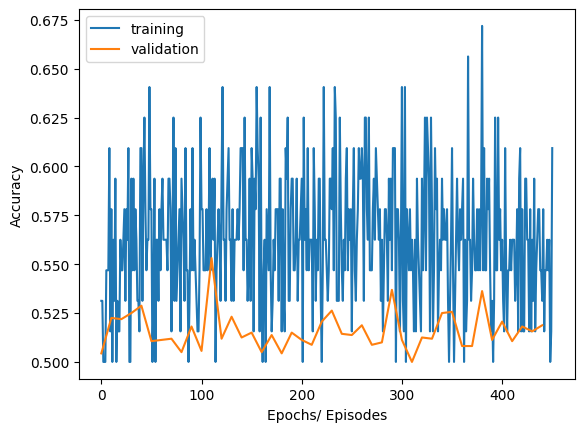

In [9]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(len(ql.accuracy))], ql.accuracy, label = 'training')
plt.plot([i*10 for i in range(len(ql.val_acc))], ql.val_acc, label = 'validation')
plt.xlabel('Epochs/ Episodes')
plt.ylabel('Accuracy')
plt.legend()
## next attempt: try putting the new token into target since it should be the future action thats being compared

In [ ]:
test_x = list(pd.read_csv('sst2_test')['sentence'])
test_y = list(pd.read_csv('sst2_test')['label'])

with torch.no_grad():
    prompts, _ = ql.get_actions_Q_input_specific_target(val_x)
    accuracy = ql.get_accuracy(test_x, test_y, ' '.join(prompts[0]))

In [ ]:
print(accuracy)

In [ ]:
ql.mlp.lm_pipeline.tokenizer.convert_ids_to_tokens([1,2,3,4])

In [ ]:
ql.epsilon 